In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix




In [2]:
# Recycling the data cleaning from analysis.ipynb, with minor change for date and year


# Import datasets with pandas
filepath = os.getcwd() + "/datasets"
dataset_4_1 = pd.read_csv(os.path.join(filepath, "4.1_final_assignments.csv"))
dataset_4_2 = pd.read_csv(os.path.join(filepath, "4.2_final_assignments.csv"))
dataset_4_3 = pd.read_csv(os.path.join(filepath, "4.3_final_assignments.csv"))
dataset_4_4 = pd.read_csv(os.path.join(filepath, "4.4_final_assignments.csv"))
dataset_4_5 = pd.read_csv(os.path.join(filepath, "4.5_final_assignments.csv"))
dataset_8_1 = pd.read_csv(os.path.join(filepath, "8.1_final_assignments.csv"))
dataset_8_2 = pd.read_csv(os.path.join(filepath, "8.2_final_assignments.csv"))
dataset_8_3 = pd.read_csv(os.path.join(filepath, "8.3_final_assignments.csv"))
dataset_8_4 = pd.read_csv(os.path.join(filepath, "8.4_final_assignments.csv"))
dataset_8_5 = pd.read_csv(os.path.join(filepath, "8.5_final_assignments.csv"))

In [3]:
df = pd.read_csv("datasets/combined_final_assignments.csv")


## Modeling

For this section, will develope and evaluate machine learning models that predict viral family from genome-level features collected by Dr. Xu and her team. This data has been preprocessed, and further cleaned by the team.

In [10]:
# Application of ML methods to predict viral taxonomy from genome level features 
# 

features = df[['Size (Kb)', 'Proteins', 'pore.size.um', 'wwtp', 'wrf', 'season', 'network']]
target_family = df['family (prediction)']
target_genus  = df['genus (prediction)']

# remove rows where the target is missing
valid_idx = target_family.notna()
features = features.loc[valid_idx]
target_family = target_family.loc[valid_idx]
target_genus = target_genus.loc[valid_idx]

## Replace any newly introduce NAN values from one-hot encoding
# Fill NaN values in categorical features with 'unknown' (One-hot encoding can not handle NaN values)
features[['wwtp','wrf','season','network']] = (
    features[['wwtp','wrf','season','network']].fillna('unknown')
)

# fill missing numerical values with median
features['Size (Kb)'] = features['Size (Kb)'].fillna(features['Size (Kb)'].median())
features['Proteins'] = features['Proteins'].fillna(features['Proteins'].median())
features['pore.size.um'] = features['pore.size.um'].fillna(features['pore.size.um'].median())

# fill missing categorical values with 'unknown'
features[['wwtp','wrf','season','network']] = (
    features[['wwtp','wrf','season','network']].fillna('unknown')
)

# use one-hot encoding for catagorical variables
# one-hot encoding converts categorial vars into elements of 0s and 1s for ML processing
X = pd.get_dummies(features, drop_first=True)
y_family = target_family
y_genus = target_genus

# final NaN replacement for safety
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
y_family = y_family.fillna("unknown")
y_genus = y_genus.fillna("unknown")

# count how many times each class appears and drop all with less than 2 (causes issues with training/test split)
counts = y_family.value_counts()
valid_classes = counts[counts >= 2].index
mask = y_family.isin(valid_classes)
X = X[mask]
y_family = y_family[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_family, test_size=0.2, stratify=y_family, random_state=42
)

# Random Forest classifier for family prediction
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)


# Neural Network classifier for family prediction (uses MLP)
# MLP is a feedforward model that maps input data onto appropriate outputs
mlp = MLPClassifier(hidden_layer_sizes=(128,64),
                    activation='relu',
                    max_iter=500)

mlp.fit(X_train, y_train)
pred_mlp = mlp.predict(X_test)



# Using extreme gradiant boosting, it preforms well for loud, heterogenous, and high dimensional data with class imbalance. 
xgb_model = XGBClassifier(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    objective="multi:softprob", 
    eval_metric="mlogloss",
    random_state=42,
    tree_method="hist"
)

# The y-labels need to encoded to become integers for XGBoost 
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb_model.fit(X_train, y_train_enc)
p = xgb_model.predict(X_test)
pred_xgb = le.inverse_transform(p)



tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
pred_dtc = tree.predict(X_test)


In [11]:
counts_genus = y_genus.value_counts()
valid_genus = counts_genus[counts_genus >= 2].index
mask_genus = y_genus.isin(valid_genus)
X_genus = X[mask_genus]
y_genus = y_genus[mask_genus]



X_train, X_test, y_train, y_test = train_test_split(
    X, y_family, test_size=0.2, stratify=y_family, random_state=42
)

# Train/test split
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_genus, y_genus, test_size=0.2, stratify=y_genus, random_state=42
)


rf_g = RandomForestClassifier(n_estimators=300, random_state=42)
rf_g.fit(X_train_g, y_train_g)
pred_rf_g = rf_g.predict(X_test_g)


mlp_g = MLPClassifier(hidden_layer_sizes=(128,64),
                    activation='relu',
                    max_iter=500)
mlp_g.fit(X_train_g, y_train_g)
pred_mlp_g = mlp_g.predict(X_test_g)

xgb_model_g = XGBClassifier(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    objective="multi:softprob", 
    eval_metric="mlogloss",
    random_state=42,
    tree_method="hist"
)
le_g = LabelEncoder()
y_train_enc_g = le_g.fit_transform(y_train_g)
y_test_enc_g = le_g.transform(y_test_g)
xgb_model_g.fit(X_train_g, y_train_enc_g)
p_g = xgb_model_g.predict(X_test_g)
pred_xgb_g = le_g.inverse_transform(p_g)

tree_g = DecisionTreeClassifier()
tree_g.fit(X_train_g, y_train_g)
pred_dtc_g = tree_g.predict(X_test_g)


/var/folders/lm/dp_9c32j3yj278s1ssxm7kcc0000gn/T/ipykernel_47405/4013079348.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_genus = X[mask_genus]


In [12]:
values = {
    "Family Predictions": [accuracy_score(y_test, pred_rf),
                           accuracy_score(y_test, pred_mlp),
                           accuracy_score(y_test, pred_xgb),
                           accuracy_score(y_test, pred_dtc)],
    "Genus Predictions": [accuracy_score(y_test_g, pred_rf_g),
                          accuracy_score(y_test_g, pred_mlp_g),
                          accuracy_score(y_test_g, pred_xgb_g),
                          accuracy_score(y_test_g, pred_dtc_g)]
}

models = ['Random Forest', 'Neural Network', 'XGBoost', 'Decision Tree']

df_results = pd.DataFrame(values, index=models)
print(df_results)


                Family Predictions  Genus Predictions
Random Forest             0.941436           0.926422
Neural Network            0.764815           0.488717
XGBoost                   0.909133           0.803949
Decision Tree             0.960260           0.969441


Observation:

Genus-level predictions appear much less accurate in comparison to Family-level predictions. This is because family has a higher taxonomic rank, and as a result are easier to cloassify since they group by broader characteristics. Meaning Family needs less specific and niche information in order to make an accurate prediction. The prefomance gap in the genus-level classification indicates that the dataset has insufficient representation for each genus, in order to make genus-level predictions. Having more data with feature distinctivness would be required in order to make accurate predictions. 

/var/folders/lm/dp_9c32j3yj278s1ssxm7kcc0000gn/T/ipykernel_31453/577476017.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Macro F1", palette="viridis")


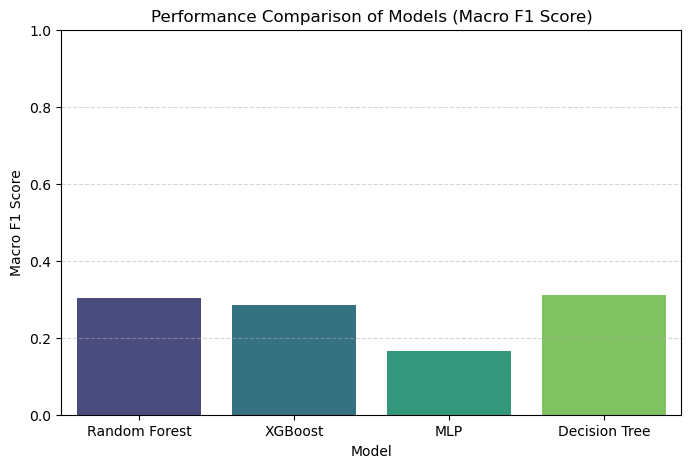


Model Performance:


,Model,Macro F1,Accuracy
0,Random Forest,0.304207,0.941436
1,XGBoost,0.285098,0.909133
2,MLP,0.165914,0.763188
3,Decision Tree,0.310792,0.960260


In [162]:

# comparing the results of the three different machine learning models used on 
metrics = {
    "Model": ["Random Forest", "XGBoost", "MLP", "Decision Tree"],
    "Macro F1": [f1_score(y_test, pred_rf, average='macro'), f1_score(y_test, pred_xgb, average='macro'), f1_score(y_test, pred_mlp, average='macro'), f1_score(y_test, pred_dtc, average='macro')],
    "Accuracy": [accuracy_score(y_test, pred_rf), accuracy_score(y_test, pred_xgb), accuracy_score(y_test, pred_mlp),  accuracy_score(y_test, pred_dtc)]
}

results_df = pd.DataFrame(metrics)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Model", y="Macro F1", palette="viridis")

plt.title("Performance Comparison of Models (Macro F1 Score)")
plt.ylabel("Macro F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("\nModel Performance:")
display(results_df)

Observation:

In order to evaluate model performance fairly across the unevenly represented viral families in the datasets, the macros-averaged F1-score was selected. Random forest, MLP, Decision Tree, and XGBoost classifiers were computed, demonstrating that random forest and Decision Tree have the highest macro f1 score. This indicates a better generalization across F1 families in that model. 

Rationalization of Choice
For the purpose of our model evaluations, we will be choosing Random Forest for further analysis. This is becuase, as seen by its accuracy score, Decision Tree is more prone to overfitting than Random forest. Furthermore, Random Forest is more robust in its handeling of outliers, while Decision Trees are less reliable with tubular data as they are more sensitive to variaitons in data. For the purpose of our analysis and evaluation of the data using a supervised machine learning model, Random Forest will be used.

In [163]:
#getting the top 10 values
top10 = y_family.value_counts().nlargest(10).index
mask = y_family.isin(top10)
X = X[mask]
y_family = y_family[mask]

# redo the train&data split to calulate cross validation for only the top 10
X_train10, X_test, y_train10, y_test = train_test_split(
    X, y_family, test_size=0.2, stratify=y_family, random_state=42
)


# Re-training random forest on the top10 
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train10, y_train10)
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))


                   precision    recall  f1-score   support

 ackermannviridae       1.00      0.98      0.99       132
aliceevansviridae       0.97      0.98      0.98       316
autographiviridae       0.99      1.00      1.00       729
   demerecviridae       1.00      1.00      1.00       202
   drexlerviridae       1.00      1.00      1.00       246
   herelleviridae       1.00      0.99      1.00       256
     kyanoviridae       0.99      1.00      0.99       154
     peduoviridae       0.99      0.98      0.98       242
    schitoviridae       1.00      1.00      1.00       229
    straboviridae       1.00      1.00      1.00       446

         accuracy                           0.99      2952
        macro avg       0.99      0.99      0.99      2952
     weighted avg       0.99      0.99      0.99      2952



Observation:

High performance is expected since curated network clusters strongly correlate with viral taxonomy.
This was determined by Tyler J. Dougan and Stephen R. Quake, in the article "Viral taxonomy derived from evolutionary genome relationships"
The article specifies that curated network cluster "captures many interesting relationships between viral families, and which creates clusters which correlate well with both the Baltimore and ICTV classifications"

<Figure size 2000x800 with 0 Axes>

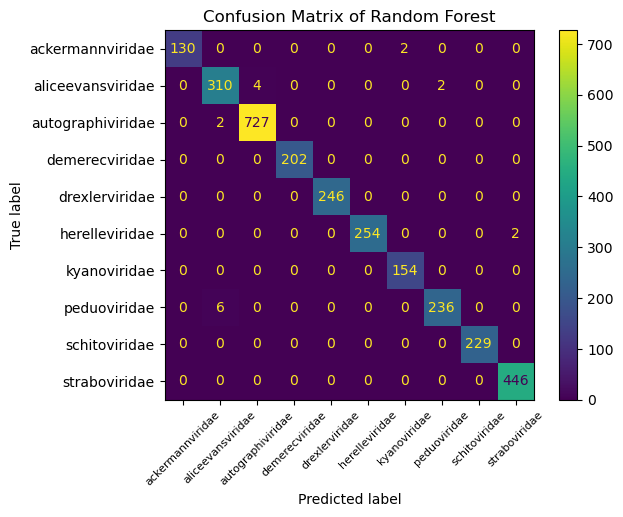

In [164]:

# Given its superior macro F1 score, again meaning a models ability to treat families equally,
# random forest will be used as the primary model for further evaluations and testing. 

# Preformance Evaluation

cm = confusion_matrix(y_test, pred_rf)

plt.figure(figsize=(20, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)

disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix of Random Forest")
plt.xticks(fontsize=8)
plt.show()



In [165]:
# Cross validation and STD of random forest model

#using k-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(rf, X_train10, y_train10, cv=kfold, scoring='f1_macro')
print("K-Fold Cross-Validation Macro F1:", cv_score)
print("Mean:", cv_score.mean(), "Std Dev:", cv_score.std())


K-Fold Cross-Validation Macro F1: [0.97843611 0.97899991 0.97822338 0.96992521 0.97863882]
Mean: 0.9768446859764539 Std Dev: 0.003469194026651383


/var/folders/lm/dp_9c32j3yj278s1ssxm7kcc0000gn/T/ipykernel_31453/3977267250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, y="Feature", x="Importance", palette="viridis")


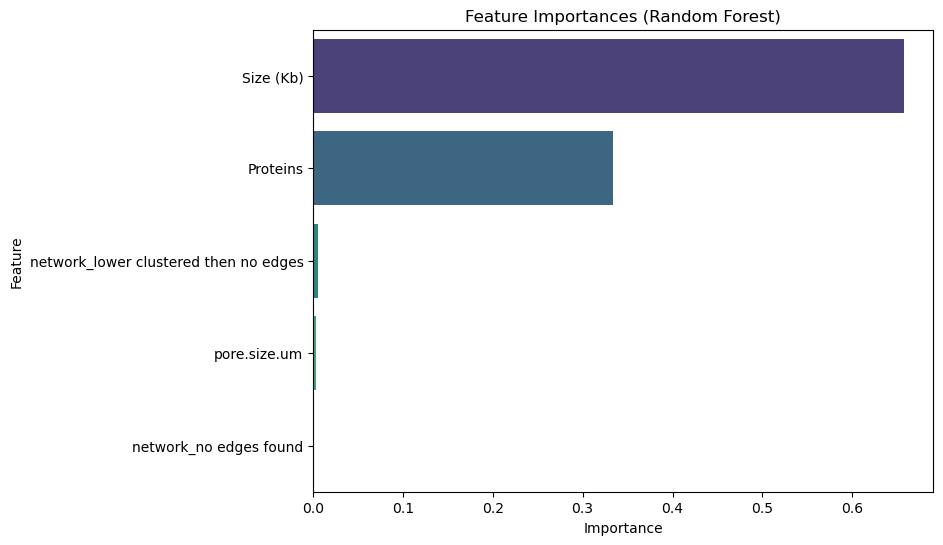

In [166]:
# Bar chart of random forest feature importance
importances = rf.feature_importances_
feature_df = pd.DataFrame({"Feature": X_train10.columns, "Importance": importances})
feature_df = feature_df.sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(data=feature_df, y="Feature", x="Importance", palette="viridis")
plt.title("Feature Importances (Random Forest)")
plt.show()

Observation:
This graph indicatest the feature importance in taxonomic predictions with the Random Forest classifier. According to the graph, genome size and protein counts are the most important in terms of taxonomic predictions. This is unsuprising for two reasons, the first of which is that, as what was found in our EDA section, the correlation between protein count and genome size is one. So it logically follows that both features would have similar weight in feature importance. Additionally, the other features are specific to the location of the collected sample, not so much as information of the sample itself. So it stands to good reason that those features are barely present as important features in the graph.